<a href="https://colab.research.google.com/github/jocksanv/neuroDecoding/blob/main/ArtDeco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#tinyurl.com/ArtDecod


# The art of decoding neural representations
## Lorenzo Posani
#### Center for Computational Neuroscience, Columbia University


A fundamental goal of neuroscience is to understand what kind of information about the world is processed by a population of neurons. Decoding neural activity with statistical and machine learning models has cemented itself as a fundamental tool to answer this question.

However, despite its wide use in the neuroscience literature, it is hard to find a comprehensive checklist of the best practices to make sure that one's analysis is solid and reproducible.

With no claim to be complete, the following notebook serves the purpose of listing some of the most common pitfalls - and best practices to avoid them - that one might encounter during their decoding journey. Have fun!

# Part 1: Basic Pitfalls

Despite the complex machinery and advanced technicalities that one might end up using in practice, decoding neural activity is a simple game:
- if neurons don't care about us labeleing two conditions differently (left panel), you want to get a ~0.5 (chance levels) performance.
- if neurons care about the two conditions and respond differently (right panel) you want a high performance, ideally ~1.


<div style="display: flex; justify-content: row;">
    <img src="https://images2.imgbox.com/da/4c/C6fo2MvN_o.png">
</div>

To illustrate the importante of best practices in decoding neural activity, we will start each section with some synthetic data that is generated **random**, that is, with no relation whatsoever to those conditions we will try to decode (as in the left panel).

In some cases, these data will give us a consistent larger-than-chance decoding performance despite being randomly sampled. We will discuss, case by case and with code examples, what best practices we can implement to avoid these false positives.


## Cross Validation
Cross validation is a fundamental tool to make sure we are properly estimating the capability of a model to discriminate the two conditions from neural activity.

In [ ]:
#@markdown #### Overfitting
#@markdown To understand why cross validation is important, let's put ourselves in a frequent case: we have recorded a lot of neurons, but we have a limited amount of trials

# imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
np.random.seed(0)

# variables
n_neurons =  300 #@param {type:"number"}
n_trials =  80 #@param {type:"number"}



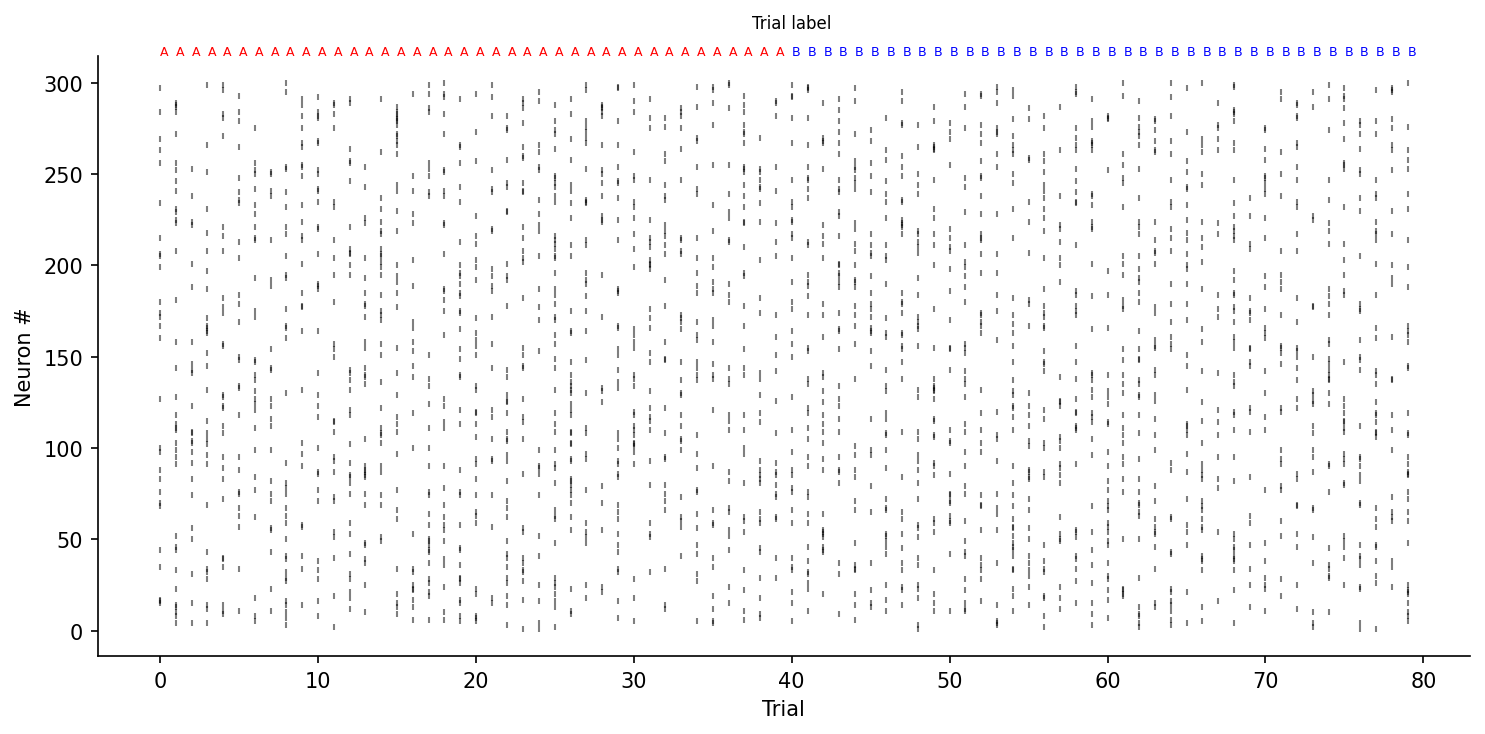

In [ ]:
mpl.rcParams['figure.dpi'] = 150

#@markdown In this hypothetical scenario, the trials are labeled with respect to two experimental conditions, called ```A``` and ```B```.

#@markdown However, we will generate some neural activity that contains <b>no information</b> about the two conditions:
#@markdown we will literally use ```np.random.rand``` to generate it.

# data generation
coding_level =  0.1

activity = np.random.rand(n_trials, n_neurons)
activity = (activity < coding_level).astype(float) # some sparsity

# labels, half A and half B
labels = np.hstack([np.repeat(-1, n_trials/2), np.repeat(1, n_trials/2)])

# visualization
def visualize_AB_activity(labels, activity, labA='A', labB='B'):
  n_trials, n_neurons = activity.shape
  f, ax = plt.subplots(figsize=(10, 5))
  ax.set_xlabel('Trial')
  ax.set_ylabel('Neuron #')
  sns.despine(ax=ax)
  ax.text(n_trials/2, n_neurons*1.1, 'Trial label', ha='center', fontsize=8)
  for t in range(n_trials):
    if labels[t] == -1:
      ax.text(t, n_neurons*1.05, labA, color='r', fontsize=6)
    if labels[t] == 1:
      ax.text(t, n_neurons*1.05, labB, color='b', fontsize=6)
  for i in range(int(n_neurons)):
    nanact = np.copy(activity[:, i])
    nanact[nanact==0] = np.nan
    ax.plot(i+nanact, marker='|', linestyle='', color='k', alpha=0.5, markersize=3)
  return f, ax


f, ax = visualize_AB_activity(labels, activity)



In [ ]:
#@markdown We will now try to decode A vs. B from this random gibberish.

#@markdown Let's choose a very simple model: ```sklearn.svm.LinearSVC``` implements a linear classifier using support vectors. I highly recommend to chech this [interactive SVM tutorial](https://lisyarus.github.io/webgl/classification.html) out to get a visual intuition on how SVMs work.<br>

from sklearn.svm import LinearSVC
mysvc = LinearSVC()


In [ ]:
#@markdown Let's train our classifier on the generated data
_ = mysvc.fit(activity, labels)

Performance: 1.0


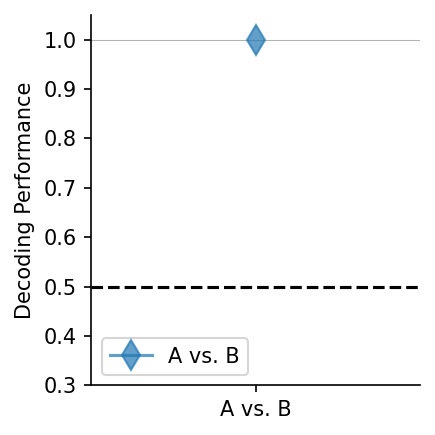

In [ ]:
#@markdown And test its performance to assess how well we can separate the two classes!
decoding_performance =  mysvc.score(activity, labels)

# visualize the performance
f, ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.axhline([0.5], linestyle='--', color='k')
ax.set_xticks([0])
ax.set_ylabel('Decoding Performance')
ax.set_ylim([0.3, 1.05])
ax.axhline([1.0], color='k', alpha=0.3, linewidth=0.5)
ax.set_xticklabels(['A vs. B'])

print("Performance:", decoding_performance)
ax.plot(decoding_performance, marker='d', markersize=10, alpha=0.7, label='A vs. B')
plt.legend()


<br><br>
What? <b>100% accuracy</b> on random data?

<div style="display: flex; justify-content: row;">
    <img src="https://media1.giphy.com/media/26ufdipQqU2lhNA4g/giphy.gif?cid=ecf05e47763ktsr6n0h8drgmlpc6y3tduq2o4548zt6zi8j7&rid=giphy.gif&ct=g">
</div>

The explanation however is quite simple: if you have more dimensions (number of neurons) than number of points (trials), you can <b>always</b> find a plane that separates two sets of points, no matter how you position and label them (except if their effective dimensionality is extremely reduced).



---

In [ ]:
#@markdown This is why we need to cross-validate our analysis!  We will do so by following a simple prescription:

#@markdown - separate training and testing trials
#@markdown - train our machinery on the _training_ trials (intuitively)
#@markdown - test it on the (you guessed it) _testing_ trials

#@markdown We will do it on many random divisions of training and testing trials, so to get a distribution of performance values.
from tqdm import tqdm

training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 100 #@param {type:"number"}

def cross_validated_decoding(labels,
                             activity,
                             training_fraction,
                             cross_validations,
                             verbose=False):
  mysvc = LinearSVC()
  # selecting A and B trials
  A_trials = np.where(labels==-1)[0]
  B_trials = np.where(labels==1)[0]

  if verbose:
    print('A trials:\n', A_trials)
    print('B trials:\n', B_trials)

  len_A = len(A_trials)
  len_B = len(B_trials)

  performances = []

  # looping on the cross_validation folds
  if verbose:
    print("\nLooping on %u cross validation folds:" % cross_validations)
  for k in tqdm(range(cross_validations)):
    np.random.shuffle(A_trials)
    np.random.shuffle(B_trials)

    # selecting training and testing trials for condition = A
    training_A = A_trials[:int(training_fraction * len_A)]
    testing_A = A_trials[int(training_fraction * len_A):]

    # selecting training and testing trials for condition = B
    training_B = B_trials[:int(training_fraction * len_B)]
    testing_B = B_trials[int(training_fraction * len_B):]

    training_trials =  np.hstack([training_A, training_B])
    testing_trials = np.hstack([testing_A, testing_B])

    # train on the training trials
    mysvc.fit(activity[training_trials], labels[training_trials])

    # test on the testing trials
    score = mysvc.score(activity[testing_trials], labels[testing_trials])
    performances.append(score)

    if verbose:
      print("\nIteration %u" % k)
      print("Training on trials:\n", training_trials)
      print("Testing on trials:\n", testing_trials)
      print("Performance: %.2f\n" % score)

  return performances

performances = cross_validated_decoding(labels,
                                        activity,
                                        training_fraction,
                                        cross_validations=5,
                                        verbose=True)


performances = cross_validated_decoding(labels,
                                        activity,
                                        training_fraction,
                                        cross_validations,
                                        verbose=False)

A trials:
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
B trials:
 [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63
 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79]

Looping on 5 cross validation folds:


100%|██████████| 5/5 [00:00<00:00, 184.45it/s]



Iteration 0
Training on trials:
 [19  0 14 27 33 20 36 16 31  1 11 18 35  3 12 29  4  7 34 39 37  9 32  5
 38  8 21 30 25 24 26 13 40 78 79 55 53 61 51 42 47 63 71 50 72 66 70 57
 68 46 45 49 56 65 62 44 54 52 73 76 48 69 77 60]
Testing on trials:
 [22  6 15 23  2 17 28 10 64 74 67 41 59 43 58 75]
Performance: 0.50


Iteration 1
Training on trials:
 [ 3 22 23 25 20 33 30 17 31  7 21 38 32 18  1 39 36 29 12 15  6 11  0  8
 34  4 10 37 26 14 16 13 77 55 61 51 57 65 70 41 44 54 43 63 67 60 75 76
 68 58 47 62 52 64 46 45 53 78 40 42 66 69 73 74]
Testing on trials:
 [27 28 19 35 24  5  2  9 79 48 71 49 72 50 56 59]
Performance: 0.50


Iteration 2
Training on trials:
 [32 39 34 26  9 18 21 20 31 38  3 30 16 24 17 25 37 35 19 29 22 14 36 27
  7  5 13  4  1  6  2 15 52 62 72 60 73 64 69 55 70 78 68 61 58 76 65 51
 79 44 56 40 48 75 49 42 43 77 71 67 50 47 41 74]
Testing on trials:
 [23 33 12  8  0 28 11 10 46 59 57 63 45 53 54 66]
Performance: 0.38


Iteration 3
Training on trials:
 [ 6  7 34

100%|██████████| 100/100 [00:00<00:00, 835.16it/s]




Let's visualize the results:




Mean performance: 0.436


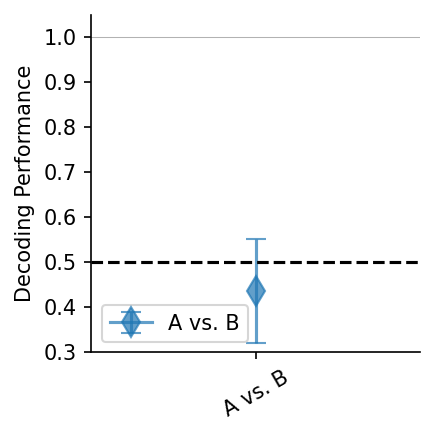

In [ ]:
# visualization
def visualize_decoding_results(performances, labA='A', labB='B'):
  f, ax = plt.subplots(figsize=(3, 3))
  sns.despine(ax=ax)
  ax.axhline([0.5], linestyle='--', color='k')
  ax.set_xticks([0])
  ax.set_ylabel('Decoding Performance')
  ax.set_ylim([0.3, 1.05])
  ax.axhline([1.0], color='k', alpha=0.3, linewidth=0.5)
  ax.set_xticklabels(['%s vs. %s' % (labA, labB)], rotation=30)

  print("Mean performance: %.3f" % np.mean(performances))
  ax.errorbar([0], np.mean(performances), np.std(performances), marker='d', capsize=5, markersize=10, alpha=0.7, label='%s vs. %s' % (labA, labB))
  plt.legend()
  return f, ax


f, ax = visualize_decoding_results(performances)



Coherently with the randomness of the whole thing, the mean performance goes to 50% (chance levels)!

> Indented block


<div style="display: flex; justify-content: row;">
    <img src="https://i.giphy.com/media/XreQmk7ETCak0/giphy.webp">
</div>

<br><br><br>
---
---



<br><br><br>

## Class balancing
Another dangerous pitfall we need to be careful of is to use <b>unbalanced classes</b> during decoding.<br><br>
This is a fairly common case when the experimental setup does not have full control of the behavior of the recorded subjects; for example, class A and B might refer to "correct" and "incorrect" trials, respectively. If subjects are well trained, or undertrained, the number of correct and incorrect trials will be unbalanced.<br><br>Let's see how having unbalanced classes can affect our decoding analysis.

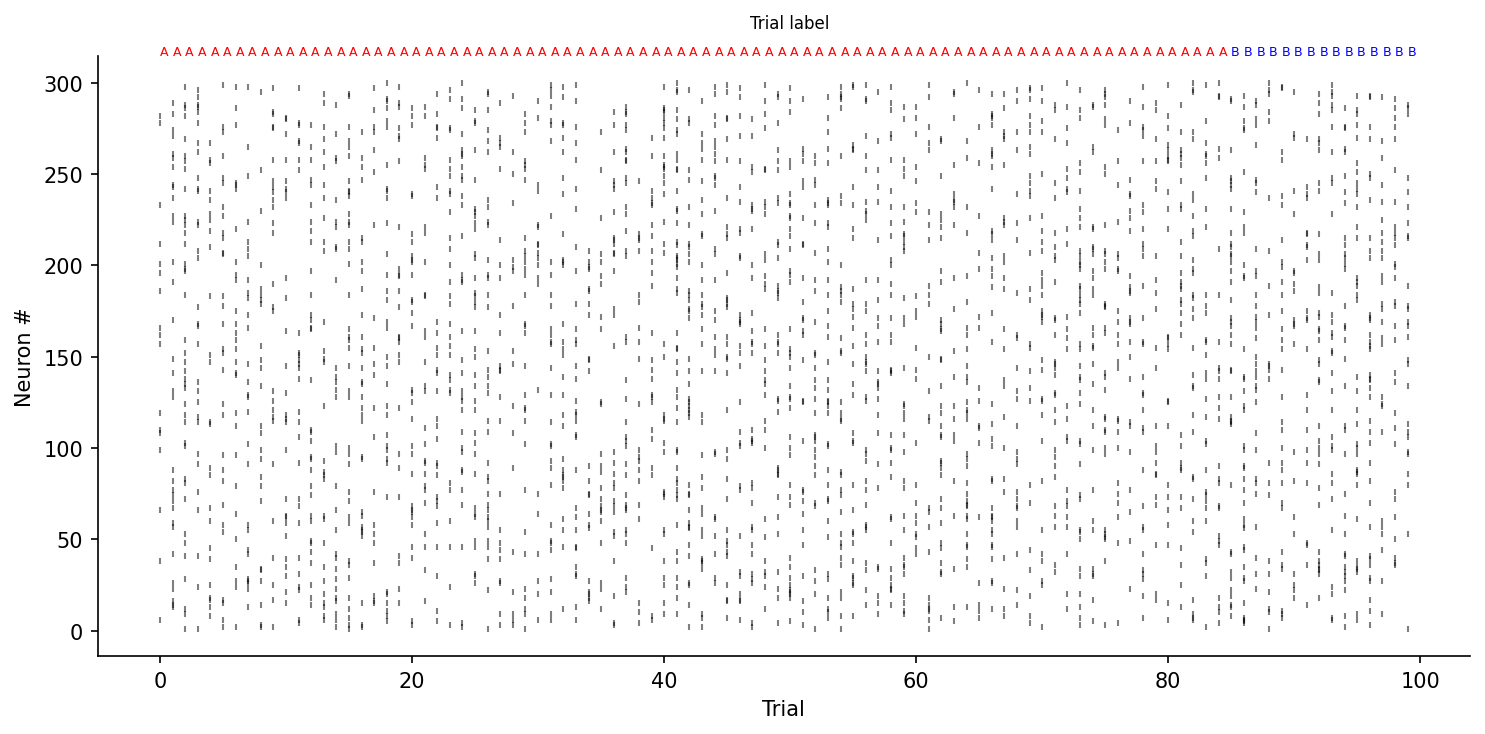

In [ ]:
#@markdown As done for the first part, we will generate synthetic neural activity that contains <b>no information</b> about the two conditions A and B.

# variables
n_neurons =  300 #@param {type:"number"}
n_trials =  100 #@param {type:"number"}
coding_level =  0.1

# random data generation
activity = (np.random.rand(n_trials, n_neurons) < coding_level).astype(float) # some sparsity

#@markdown However, class A will be much more represented than B
A_fraction =  0.85 #@param {type:"slider", min:0.5, max:0.95, step:0.01}
labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])

# visualization
f, ax = visualize_AB_activity(labels, activity)



100%|██████████| 100/100 [00:00<00:00, 547.20it/s]


Mean performance: 0.782


(<Figure size 450x450 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22b21cbca0>)

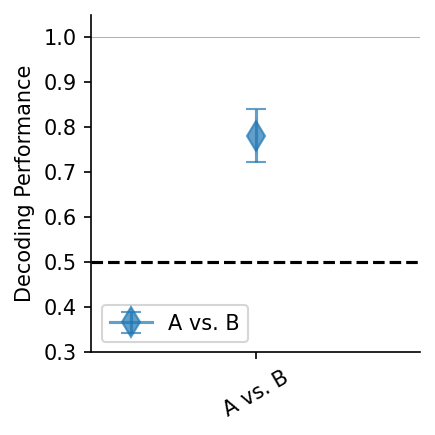

In [ ]:
#@markdown We can re-use our ```cross_validated_deocding()``` function to analyze the decoding performance of A vs. B from the (random) neural activity. Given the randomness, we expect a chance levels performance around 0.5.
A_fraction =  0.85 #@param {type:"slider", min:0.5, max:0.95, step:0.01}
labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])

training_fraction =  0.85 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 100 #@param {type:"number"}

performances = cross_validated_decoding(labels, activity,
                                        training_fraction,
                                        cross_validations)

visualize_decoding_results(performances)



---

<br>
<br>

However, we find again a consistent **larger-than-chance** performance from random data!

<div style="display: flex; justify-content: row;">
    <img src="https://64.media.tumblr.com/b99e4d1c4903de8aeb7a10d7610ef903/tumblr_nttfte7hdY1qamlhro2_250.gifv">
</div>


100%|██████████| 25/25 [00:00<00:00, 64.77it/s]


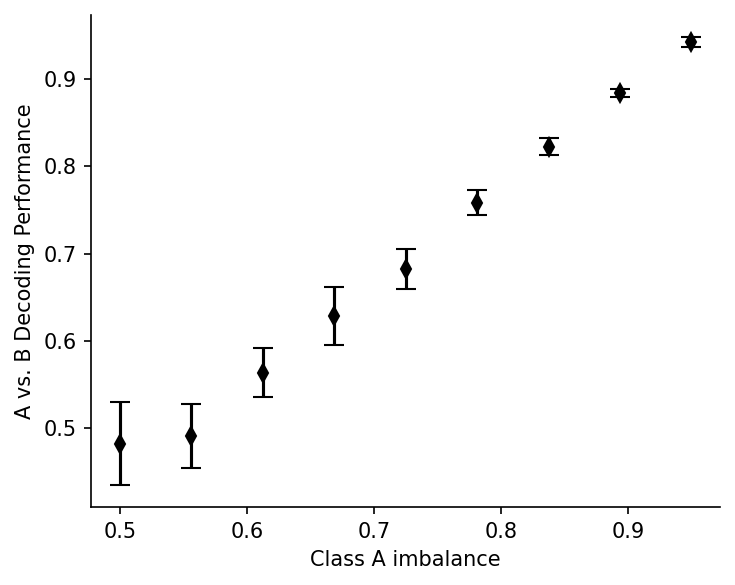

In [ ]:
#@markdown By playing with the ```A_fraction``` parameter above, you will notice that there is a clear correlation between the over-representation of a class and the false positive performance of our decoding analysis.
#@markdown <br><br> Let's analyze it systematically in a non-overfitting setup (n_trials > n_features).

n_neurons =  100 #@param {type:"number"}
n_trials =  1000 #@param {type:"number"}
cross_validations =  25 #@param {type:"number"}

f, ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
ax.set_xlabel('Class A imbalance')
ax.set_ylabel('A vs. B Decoding Performance')

for A_fraction in np.linspace(0.5, 0.95, 9):
  activity = (np.random.rand(n_trials, n_neurons) < coding_level).astype(float) # some sparsity
  labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])
  performances = cross_validated_decoding(labels,
                                          activity,
                                          training_fraction,
                                          cross_validations)
  ax.errorbar(A_fraction, np.mean(performances), np.std(performances), capsize=5, color='k', marker='d')




<br><br>**What's going on here?**<br>
The dumb machine is smarter than we think! Since there is no real information to separate A vs. B, it learns a trick to maximize the performance: **bias its guess towards the most populated class**!<br><br>We can check it by visualizing the predicted labels by our trained SVC<br>

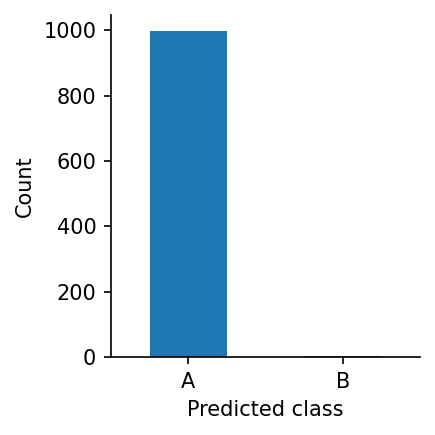

In [ ]:
A_fraction = 0.9
activity = (np.random.rand(n_trials, n_neurons) < coding_level).astype(float) # some sparsity
labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])

mysvc = LinearSVC()
mysvc.fit(activity, labels)
labels = mysvc.predict(activity)

f, ax = plt.subplots(figsize=(3, 3))
sns.despine(ax=ax)
ax.hist(labels, bins=[-1.5,-0.5,0.5,1.5])
ax.set_xticks([-1, 1])
ax.set_xticklabels(['A', 'B'])
ax.set_xlim([-2, 2])
ax.set_xlabel('Predicted class')
_ = ax.set_ylabel('Count')


In [ ]:
#@markdown How can we avoid these false positives? There are two main possibilities <br>(1) change the weight of both classes in the SVC algorithm using the keyword ```class_weight=balanced```<br>(2) resample (up, down, random) the training data in a balanced way
#@markdown <br><br> Let's try the second approach: we re-write our cross validation decoding function by adding a parameter ```n_resampling``` that specifies the number of random samples we will draw for the training set of each class. This will allow the decoder to be trained on the same number of trials for the class A and B.

n_resampling = 100 #@param {type:"number"}

A_fraction = 0.9 #@param {type:"slider", min:0.1, max:0.98, step:0.01}

activity = (np.random.rand(n_trials, n_neurons) < coding_level).astype(float) # some sparsity
labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])

#@markdown <br><br> <b>very important</b>: trial resampling must be performed <b>after</b> the training-testing division. Otherwise, we will end up with the same data point in training and testing data!

def balanced_cross_validated_decoding(labels,
                                      activity,
                                      training_fraction,
                                      cross_validations,
                                      n_resampling, # added this keyword
                                      verbose=False):
  mysvc = LinearSVC()

  A_trials = np.where(labels==-1)[0]
  B_trials = np.where(labels==1)[0]
  if verbose:
    print('A trials:\n', A_trials)
    print('B trials:\n', B_trials)
  len_A = len(A_trials)
  len_B = len(B_trials)

  performances = []

  if verbose:
    print("\nLooping on %u cross validation folds:" % cross_validations)

  for k in range(cross_validations):
    np.random.shuffle(A_trials)
    np.random.shuffle(B_trials)

    # selecting training and testing trials for condition = A
    training_A = A_trials[:int(training_fraction * len_A)]
    testing_A = A_trials[int(training_fraction * len_A):]

    # selecting training and testing trials for condition = B
    training_B = B_trials[:int(training_fraction * len_B)]
    testing_B = B_trials[int(training_fraction * len_B):]

    # ===> resampling trials <===
    training_A = np.random.choice(training_A, n_resampling)
    training_B = np.random.choice(training_B, n_resampling)
    testing_A = np.random.choice(testing_A, n_resampling)
    testing_B = np.random.choice(testing_B, n_resampling)
    # ===========================

    training_trials =  np.hstack([training_A, training_B])
    testing_trials = np.hstack([testing_A, testing_B])


    mysvc.fit(activity[training_trials], labels[training_trials])
    score = mysvc.score(activity[testing_trials], labels[testing_trials])
    performances.append(score)

    if verbose:
      print("\nIteration %u" % k)
      print("Training on trials:\n", training_trials)
      print("Testing on trials:\n", testing_trials)
      print("Performance: %.2f\n" % score)

  return performances



Mean performance: 0.470


(<Figure size 450x450 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22b6bcd880>)

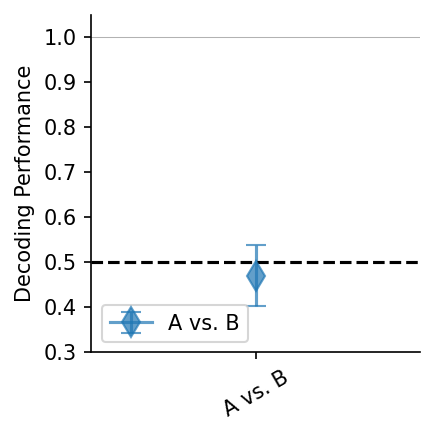

In [ ]:
#@markdown Let's try it on some very unbalanced data (```A_fraction = 0.9```)
performances = balanced_cross_validated_decoding(
    labels,
    activity,
    training_fraction=0.8,
    cross_validations=100,
    n_resampling=n_resampling
    )

visualize_decoding_results(performances)


<br><br>Our balanced decoding analysis behaves very well and returns a performance compatible with chance levels!

<div style="display: flex; justify-content: row;">
    <img src="https://media2.giphy.com/media/AL10PPC3eZhxC/giphy.gif?cid=ecf05e47wjqjgqyhji9c6q8zr7cug9de8uhtq8q5n707hpwd&rid=giphy.gif&ct=g">
</div>
<br><br><br>



## Autocorrelations
Another important pitfall for neural data decoding, especially relevant to data acquired with calcium imaging and fMRI, is the **autocorrelation in time** of the recorded neural features.<br><br>
If the autocorrelation time of features spans more than one trial, or time bin (if we decode without a trial structure), we might end up with data points in the training and testing sets that artificially share similar features, yielding again to false positives.<br><br>
Similarly, if there is an artifact in the data whose time scale spans more than one data point, we might end up decoding the artifact instead of real mutual information between the variables and the neural activity.<br><br> Let's see a practical example.

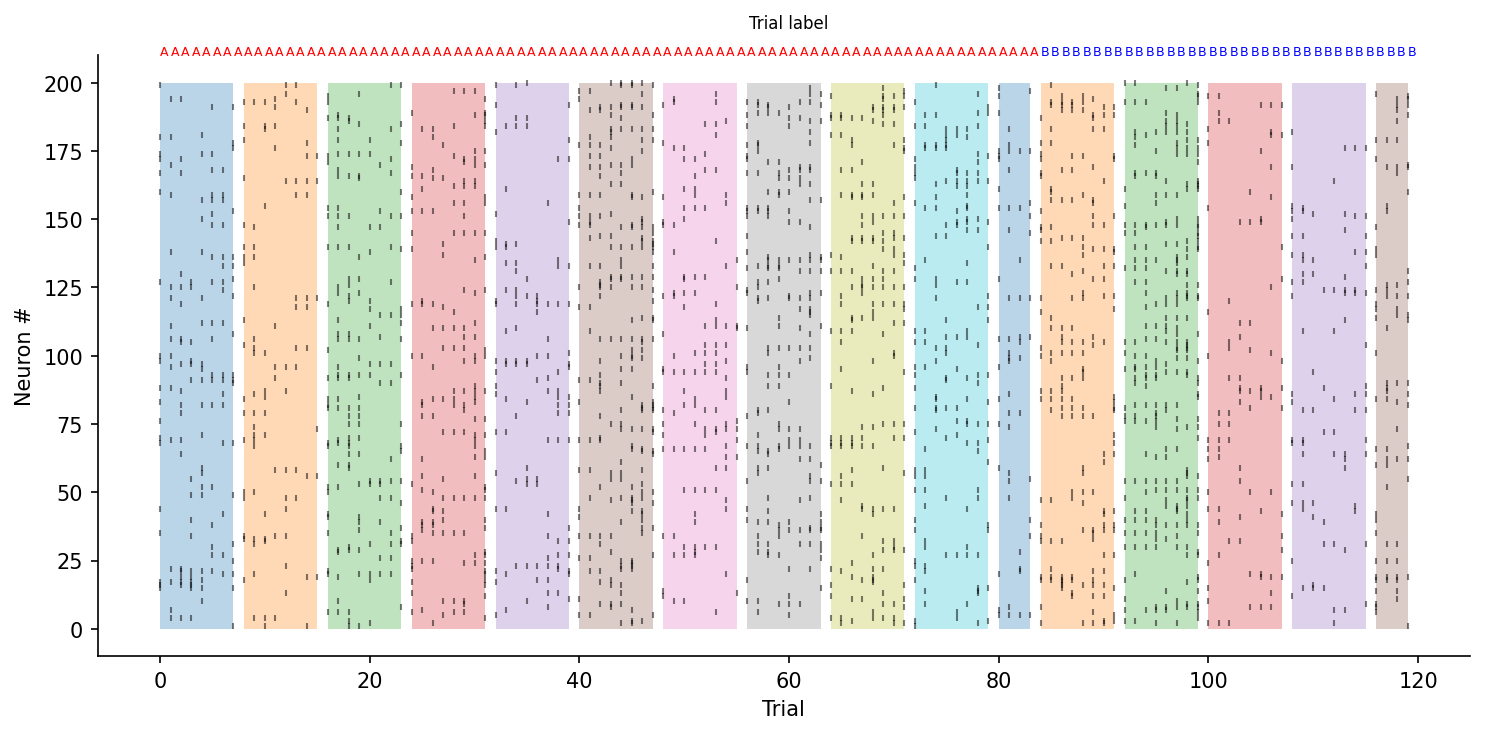

In [ ]:
#@markdown <br><br>Let's create again a session of random neural activity. This time we will add a slow-decaying convolution artifact that spans groups of ```trials_per_block``` trials.
#@markdown <br><br>This will mimic a recording session made of blocks of ```trials_per_block``` trials each, separated from each other by enough time to avoid that the slow convolution effect to leak between blocks.<br>
from math import ceil
np.random.seed(0)

n_neurons = 200 #@param {type:"number"}
n_trials = 120 #@param {type:"number"}
trials_per_block =  8#@param {type:"number"}

#@markdown To make our life easier (not), we will again use unbalanced data
A_fraction = 0.7 #@param {type:"slider", min:0.1, max:0.98, step:0.01}

#@markdown A $\tau$ parameter will control the typical time scale of autocorrelation
tau = 1.52 #@param {type:"slider", min:1, max:10, step:0.01}

# generate activity
activity = (np.random.rand(n_trials, n_neurons) < coding_level).astype(float) # some sparsity
labels = np.hstack([-1*np.ones(int(n_trials * A_fraction)), np.ones(n_trials - int(n_trials*A_fraction))])

# generate the block structure
blocks_A = np.repeat(range(ceil(n_trials*A_fraction/trials_per_block)), trials_per_block)[:int(n_trials*A_fraction)]
blocks_B = np.repeat(range(ceil(n_trials*(1-A_fraction)/trials_per_block)), trials_per_block)[:(n_trials-int(n_trials*A_fraction))]
blocks_B += np.max(blocks_A)+1
blocks = np.hstack([blocks_A, blocks_B])

# add slow convolution within blocks

for block in np.unique(blocks):
  block_trials = np.where(blocks==block)[0]
  block_activity = activity[block_trials]
  T = len(block_trials)
  for t in range(1, T):
    M = np.eye(n_neurons)
    for i in range(n_neurons):
      if np.random.rand() < 1./tau:
        np.random.shuffle(M[i])
    block_activity[t] = np.dot(M, block_activity[t-1])
  activity[block_trials] = block_activity

# visualize activity and blocks
f, ax = visualize_AB_activity(labels, activity)

for block in np.unique(blocks):
  block_trials = np.where(blocks==block)[0]
  ax.fill_between(block_trials, n_neurons, alpha=0.3)







Mean performance: 0.788


(<Figure size 450x450 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22b68713d0>)

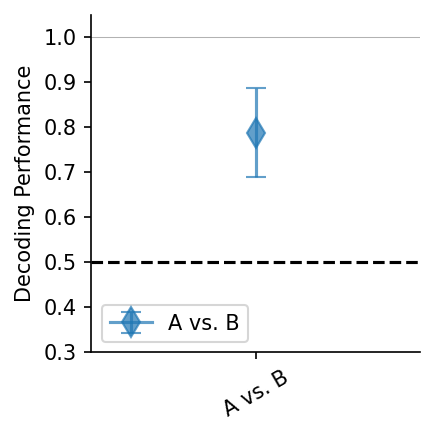

In [ ]:
#@markdown Now let's try our **best** cross-validated balanced analysis on this data!

training_fraction =  0.85 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 100 #@param {type:"number"}
n_resampling = 150 #@param {type:"number"}

performances = balanced_cross_validated_decoding(
    labels,
    activity,
    training_fraction=training_fraction,
    cross_validations=cross_validations,
    n_resampling=n_resampling
    )

visualize_decoding_results(performances)



Despite our best balanced cross validated effors, we still get a **larger than chance** performance in supposedly random data!<br><br>

<div style="display: flex; justify-content: row;">
    <img src="https://memeguy.com/photos/images/trying-to-make-it-through-a-lecture-when-im-in-desperate-need-of-a-shit-55179.gif">
</div>


What to do?<br><br>
To avoid these very dangerous false positives, we need to make sure that **trials from the same block never go into training _and_ testing at the same time**.<br><br>

In practice, we have to separate training and testing **blocks** for each **cross validation** fold!
<br><br>

In [ ]:
def block_structured_balanced_cross_validated_decoding(
    labels,
    activity,
    training_fraction,
    cross_validations,
    n_resampling,
    block_index,
    verbose=False):

  mysvc = LinearSVC()

  A_trials = np.where(labels==-1)[0]
  A_blocks = np.unique(block_index[A_trials])

  B_trials = np.where(labels==1)[0]
  B_blocks = np.unique(block_index[B_trials])

  if verbose:
    print('A trials:\n', A_trials)
    print('B trials:\n', B_trials)
    print('A blocks:\n', A_blocks)
    print('B blocks:\n', B_blocks)

  len_A = len(A_blocks)
  len_B = len(B_blocks)

  performances = []

  if verbose:
    print("\nLooping on %u cross validation folds:" % cross_validations)

  for k in tqdm(range(cross_validations)):
    np.random.shuffle(A_blocks)
    np.random.shuffle(B_blocks)

    # selecting training and testing blocks for condition = A
    training_blocks_A = A_blocks[:int(training_fraction * len_A)]
    testing_blocks_A = A_blocks[int(training_fraction * len_A):]

    # defining training and testing trials fromt the selected blocks
    training_trials_A = np.hstack([np.where(block_index == b)[0] for b in training_blocks_A])
    testing_trials_A = np.hstack([np.where(block_index == b)[0] for b in testing_blocks_A])

    # selecting training and testing blocks for condition = B
    training_blocks_B = B_blocks[:int(training_fraction * len_B)]
    testing_blocks_B = B_blocks[int(training_fraction * len_B):]

    # defining training and testing trials fromt the selected blocks
    training_trials_B = np.hstack([np.where(block_index == b)[0] for b in training_blocks_B])
    testing_trials_B = np.hstack([np.where(block_index == b)[0] for b in testing_blocks_B])

    # ===> resampling trials <===
    training_trials_A = np.random.choice(training_trials_A, n_resampling)
    training_trials_B = np.random.choice(training_trials_B, n_resampling)
    testing_trials_A = np.random.choice(testing_trials_A, n_resampling)
    testing_trials_B = np.random.choice(testing_trials_B, n_resampling)
    # ===========================

    # concatenating data from sampled blocks
    training_trials =  np.hstack([training_trials_A, training_trials_B])
    testing_trials = np.hstack([testing_trials_A, testing_trials_B])

    # training the classifier
    mysvc.fit(activity[training_trials], labels[training_trials])

    # testing the classifier
    score = mysvc.score(activity[testing_trials], labels[testing_trials])
    performances.append(score)

    if verbose:
      print("\nIteration %u" % k)
      print("Training on trials:\n", training_trials)
      print("Testing on trials:\n", testing_trials)
      print("Performance: %.2f\n" % score)

  return performances


100%|██████████| 100/100 [00:01<00:00, 59.51it/s]

Mean performance: 0.495


(<Figure size 450x450 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f22b67d2f10>)

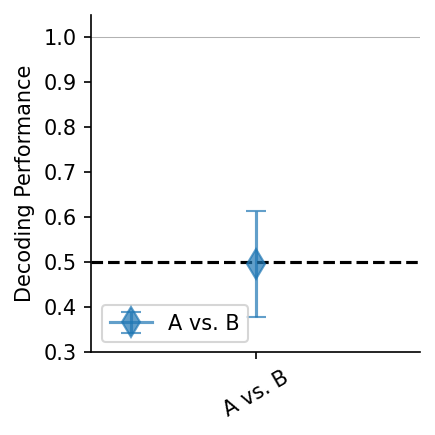

In [ ]:
#@markdown Let's see how it works on this data!
training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 100 #@param {type:"number"}
n_resampling = 150 #@param {type:"number"}

performances = block_structured_balanced_cross_validated_decoding(
    labels,
    activity,
    training_fraction=training_fraction,
    cross_validations=cross_validations,
    n_resampling=n_resampling,
    block_index=blocks, # <==== the block index!
    verbose=False
    )

visualize_decoding_results(performances)

Coherently with the randomness of the data, we find a decoding performance at **chance levels**!
<br><br>**well done!**


<div style="display: flex; justify-content: row;">
    <img src="https://media4.giphy.com/media/mGK1g88HZRa2FlKGbz/giphy.gif?cid=790b7611cc31d71656612202bd13dea6e6d0290b68c4ce9b&rid=giphy.gif&ct=g">
</div>


<br><br><br>
---
---



<br><br><br>



# Part 2: Advanced Stuff
In this second part, we will start from synthetic neural data that contains _some_ information about the two conditions we are trying to decode.

We will first learn how to test the significance of our performance values with a properly-designed **null model**.

Then we will see how a variable that is completely irrelevant to the neural activity but happens to correlate with one to which the activity is actually responding can be dangerously mistaken for being represented in the neural data. We will illustrate this **confounding effects** problem with an example and introduce a ```Decodanda```, a framework that allows us to get around it by properly balancing the data sampling process.

We will then learn how to improve the decoding performance by pooling different subjects together in the same analysis (**pseudo-simultaneous**).

Finally, we will see how to analyze the **geometry of the neural representations** of two or three variables via the cross-condition generalization performance (**CCGP**) analysis.
<br><br>


## Null model
Let's say we happen to have a data set including neural activity that actually responds to the variable we want to decode (finally). We get a performance value (mean over cross validation folds) of 0.72.

How can we tell if this value is significant or not? To test its significance, we need to compare it to a **null model distribution**.

The design principle behind null models is that the value coming from the data has to be compared with a _distribution_ of values that come from a collection of data sets that _share all features except the one we want to test_ with the original data.

Importantly, we need to make sure that the **_same analysis_** we performed on the original data is performed on these null data sets.

In our case, the specific feature we care about is that neural activity in trials labeled as ```A``` behaves differently than in trials labeled as ```B```, in a consistent way. We can therefore create a null data set by **_shuffling the labels_** to break the relationship between labels and activity.

We will then process the shuffled data through **_the same cross validated pipeline_** we used to get our first performance value.

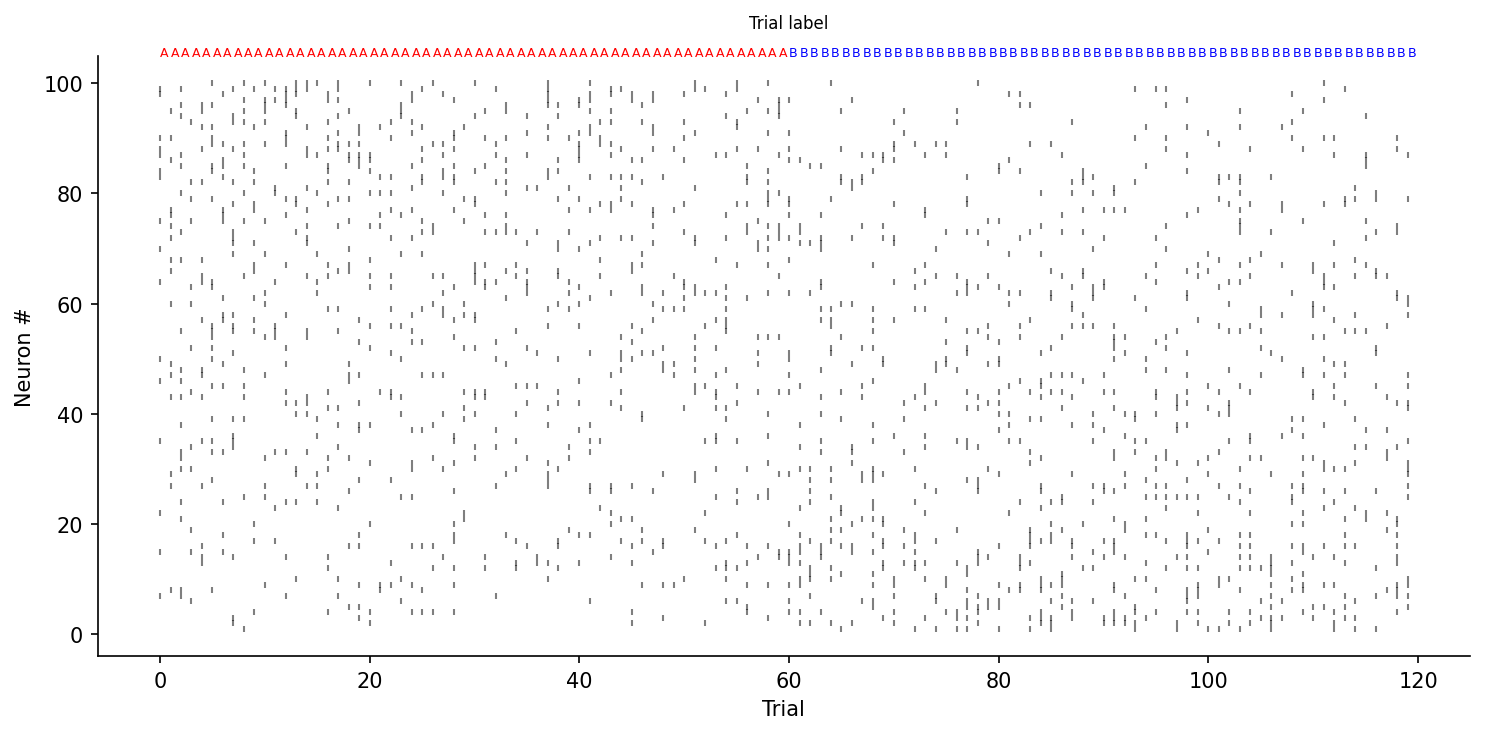

In [ ]:
#@markdown Let's create an example of activity that actually responds to a variable.

#@markdown Let's imagine we record from the visual cortex of a subject exposed to two different visuali stimuli, A and B.

#@markdown We create a synthetic version of this scenario by sampling from two gaussian distributions, one for A and one for B, with unitary diagonal covariance and random centers in the activity space.

#@markdown The two centers are placed at a mutual distance that is controlled by the ```AB_separation``` parameter. After sampling the data, we will binarize them with a thresholding non linearity.
np.random.seed(0)

AB_separation = 1.4 #@param {type:"slider", min:0.1, max:5, step:0.1}

n_neurons = 100 #@param {type:"number"}
n_trials = 120 #@param {type:"number"}

def generate_AB_activity(n_neurons, n_trials, separation):
  coding_level = 0.25
  # generate activity for stimulus A
  mean_A = np.random.rand(n_neurons) * separation # define the mean
  cov_A = np.eye(n_neurons) # unitary diagonal covariance matrix

  activity_A = np.random.multivariate_normal(
      mean_A, cov_A, int(n_trials/2))  # just sample from the gaussian
  activity_A = (np.abs(activity_A) < coding_level).astype(float)

  # generate activity for stimulus B
  mean_B = np.random.rand(n_neurons) * separation
  cov_B = np.eye(n_neurons)

  activity_B = np.random.multivariate_normal(
      mean_B, cov_B, int(n_trials/2))
  activity_B = (np.abs(activity_B) < coding_level).astype(float)

  # put the activity together
  V1_activity = np.vstack([activity_A, activity_B])
  stimulus_labels = np.hstack([-1*np.ones(int(n_trials/2)), np.ones(int(n_trials/2))])

  # order the activity for plotting purposes
  selectivity = np.mean(activity_A, 0) - np.mean(activity_B, 0)
  order = np.argsort(selectivity)
  V1_activity = V1_activity[:, order]

  # return activity and labels
  return V1_activity, stimulus_labels


# let's call the function to get the activity
V1_activity, stimulus_labels = generate_AB_activity(n_neurons,
                                                    n_trials,
                                                    AB_separation)

# let's visualize it
f, ax = visualize_AB_activity(stimulus_labels, V1_activity)


Mean performance: 0.678


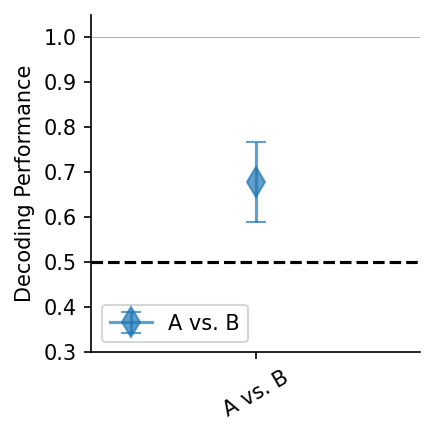

In [ ]:
#@markdown Looks like there is some visible (almost?) difference, but is it enough to decode it? Let's try with our cross validated balanced pipeline.

training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations =  20#@param {type:"number"}
n_resampling = 150 #@param {type:"number"}

performances = balanced_cross_validated_decoding(
    labels=stimulus_labels,
    activity=V1_activity,
    training_fraction=training_fraction,
    cross_validations=cross_validations,
    n_resampling=n_resampling
    )

f, ax = visualize_decoding_results(performances)

#@markdown We can't use a t-test against 0.5 because it depends on the number of cross validations, which is completely under our control!
# import scipy
# scipy.stats.ttest_1samp(performances, 0.5)

In [ ]:
#@markdown The mean performance is larger than 0.5, but how can we tell if it is significant?

#@markdown Let's follow the null model principle: we keep the data intact and we only break its relationship with the ```A``` and ```B``` labeling

#@markdown We will repeat the shuffling ```nshuffles``` times, and each time we will run the whole cross validated analysis on the resulting null data set.
nshuffles = 50 #@param {type:"number"}

null_performances = []

for i in tqdm(range(nshuffles)):
  null_labels = np.copy(stimulus_labels) # these will be shuffled
  np.random.shuffle(null_labels) # <- here

  null_p = balanced_cross_validated_decoding(
      labels=null_labels,
      activity=V1_activity,
      training_fraction=training_fraction,
      cross_validations=cross_validations,
      n_resampling=n_resampling
      )
  null_performances.append(np.mean(null_p))


100%|██████████| 50/50 [00:11<00:00,  4.46it/s]


/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


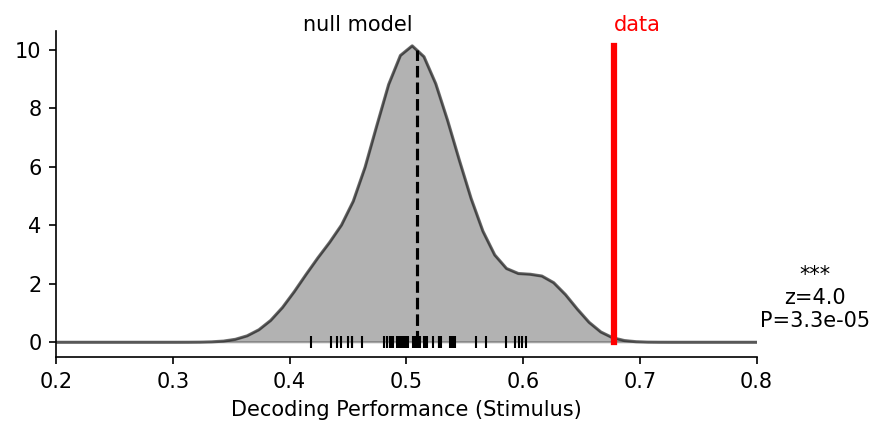

In [ ]:
#@markdown Let's visualize the performance against the null model distribution and see if the effect is significant!

perf = np.mean(performances)

def visualize_performance_nullmodel(perf, null_performances):
  import scipy
  # computing the P value of the z-score
  from scipy.stats import norm
  null_mean = np.nanmean(null_performances)
  z = (perf - null_mean) / np.nanstd(null_performances)
  p = norm.sf(abs(z))

  def p_to_ast(p):
      if p < 0.001:
          return '***'
      if p < 0.01:
          return '**'
      if p < 0.05:
          return '*'
      if p >= 0.05:
          return 'ns'

  # visualizing
  f, ax = plt.subplots(figsize=(6, 3))
  kde = scipy.stats.gaussian_kde(null_performances)
  null_x = np.linspace(0., 1.0, 100)
  null_y = kde(np.linspace(0.1, 0.9, 100))
  ax.plot(null_x, null_y, color='k', alpha=0.5)
  ax.fill_between(null_x, null_y, color='k', alpha=0.3)
  ax.text(null_x[np.argmax(null_y)], np.max(null_y)*1.05, 'null model', ha='right')
  sns.despine(ax=ax)
  ax.plot([perf, perf], [0, np.max(null_y)], color='red', linewidth=3)
  ax.text(perf, np.max(null_y)*1.05, 'data', ha='left', color='red')
  ax.set_xlabel('Decoding Performance (Stimulus)')
  ax.set_xlim([0.2, 0.8])
  ax.text(0.85, 0.05*np.max(null_y), '%s\nz=%.1f\nP=%.1e' % (p_to_ast(p), z, p), ha='center')
  ax.plot(null_performances, np.zeros(len(null_performances)), linestyle='', marker='|', color='k')
  _ = ax.plot([null_mean, null_mean], [0, kde(null_mean)], color='k', linestyle='--')
  return f, ax, z, p

f, ax, z, p = visualize_performance_nullmodel(perf, null_performances)


<br><br><br>
It might not be a flashy 99% value, but it is **significantly larger than the null model distribution**! Ready to go in the paper figures!
<br><br><br>
---
---


## Disentangling confounds
Say we are running an experiment where a subject has to learn a stimulus-action association: when stimulus A pops out on the screen, the subject has to move a lever to the right, when B is presented, the subject needs to move the lever to the left.

As for the example above, during stimulus presentation we record from the subject's visual cortex. After training, the subject performs the task with ~ 80% accuracy (not great, not terrible).

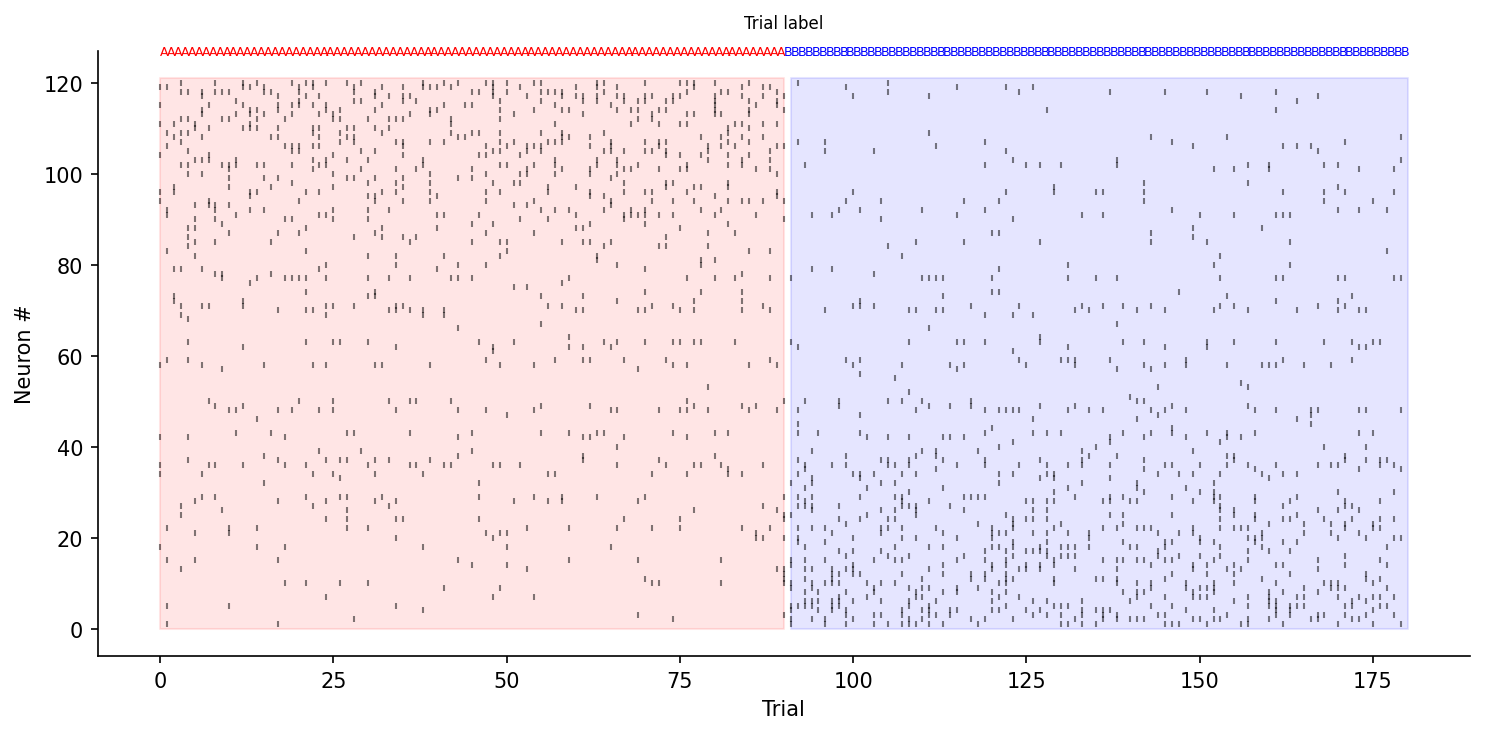

In [ ]:
#@markdown Let's create some synthetic data that responds to the visual stimuli
np.random.seed(0)

AB_separation = 3 #@param {type:"slider", min:0.1, max:5, step:0.1}

n_neurons = 120 #@param {type:"number"}
n_trials = 180 #@param {type:"number"}
V1_activity, stimulus_labels = generate_AB_activity(n_neurons,
                                                    n_trials,
                                                    AB_separation)

f, ax = visualize_AB_activity(stimulus_labels, V1_activity)

ax.fill_between([0, n_trials/2], n_neurons+1, color='r', alpha=0.1)
ax.fill_between([n_trials/2+1, n_trials], n_neurons+1, color='b', alpha=0.1)


Mean performance: 0.986


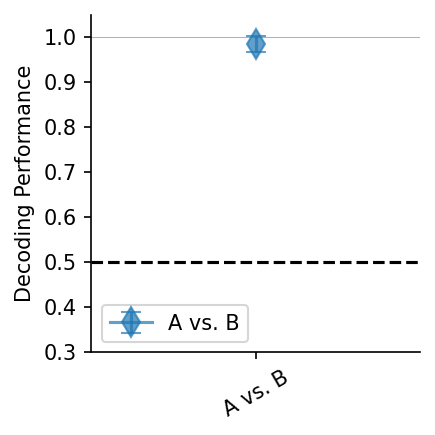

In [ ]:
#@markdown We can easily (and legitimately!) decode A vs. B from the sampled activity:

training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 50 #@param {type:"number"}
n_resampling = 100 #@param {type:"number"}

performances = balanced_cross_validated_decoding(
    labels=stimulus_labels,
    activity=V1_activity,
    training_fraction=training_fraction,
    cross_validations=cross_validations,
    n_resampling=n_resampling
    )

f, ax = visualize_decoding_results(performances)



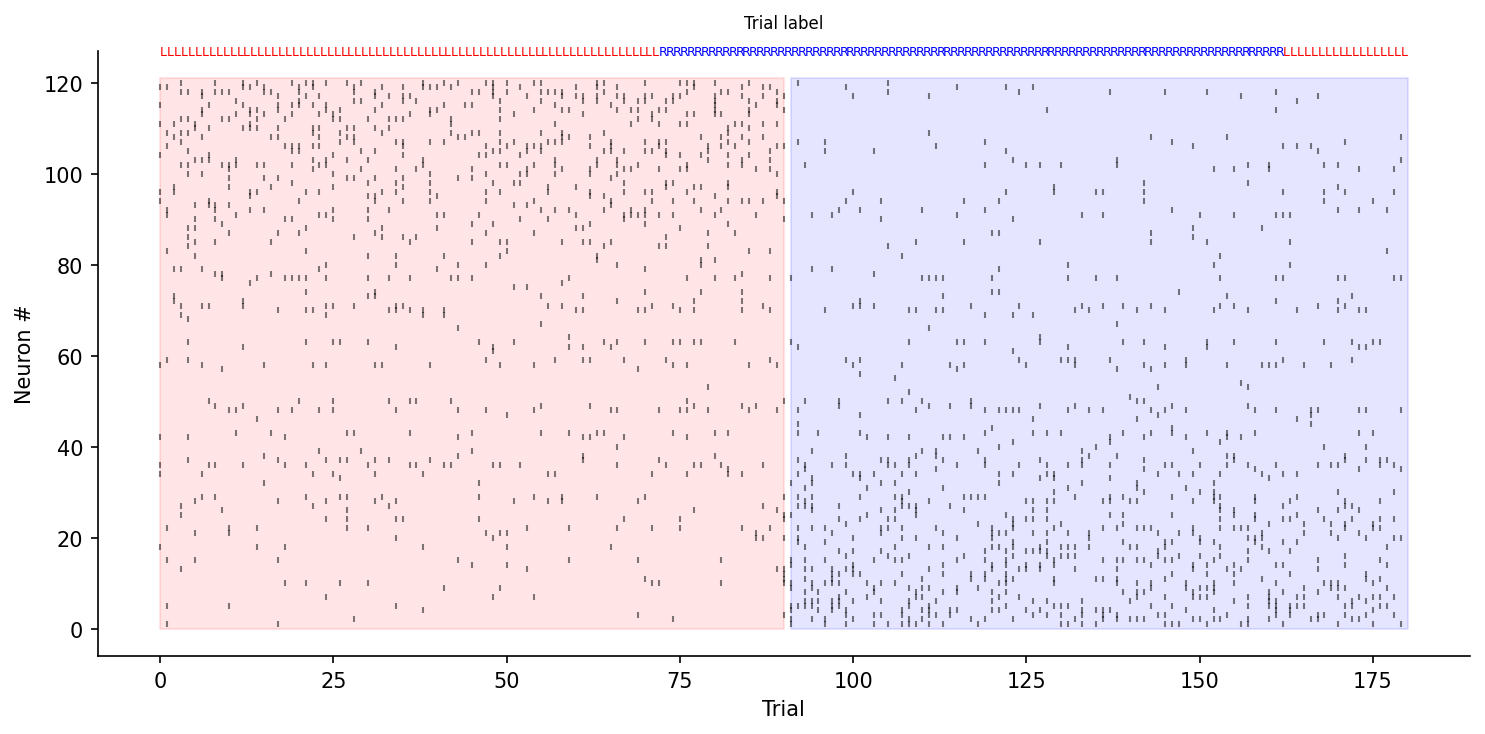

In [ ]:
#@markdown As we mentioned above, the subject performs with ~80% accuracy the task. Let's create a simple implementation of this behavior

action_labels = np.copy(stimulus_labels)
action_labels[int(2*n_trials/5) : int(n_trials/2)] = 1
action_labels[int(9*n_trials/10):] = -1
f, ax = visualize_AB_activity(action_labels, V1_activity, 'L', 'R')

ax.fill_between([0, n_trials/2], n_neurons+1, color='r', alpha=0.1)
ax.fill_between([n_trials/2+1, n_trials], n_neurons+1, color='b', alpha=0.1)


We can clearly see that the **action** variable (left, right) correlates - as it should by experimental design - with the visual stimulus
<br><br>

100%|██████████| 25/25 [00:03<00:00,  7.71it/s]
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


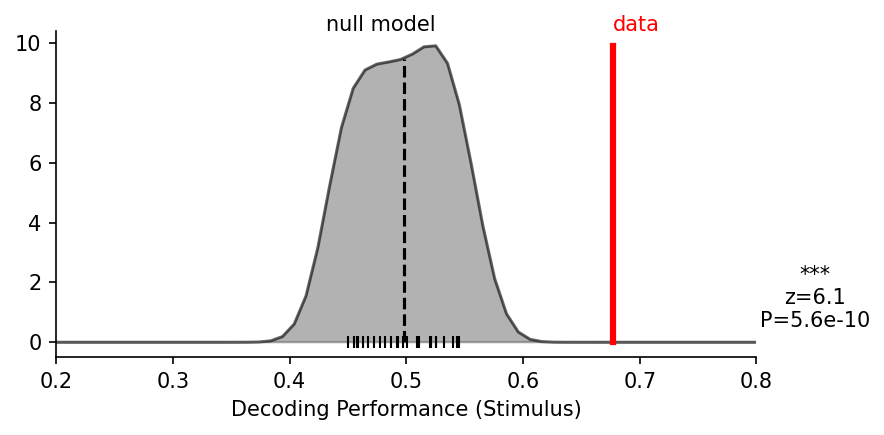

In [ ]:
#@markdown We know that our synthetic V1 activity does not respond to ```action```, as we sampled it according to the ```stimulus``` value.

#@markdown But what happens if we apply our best balanced cross validated pipeline to decode ```action``` from V1 activity?

training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 25 #@param {type:"number"}
n_resampling = 100 #@param {type:"number"}

performances = balanced_cross_validated_decoding(
    labels=action_labels, # <==== trials labeled according to action
    activity=V1_activity,
    training_fraction=training_fraction,
    cross_validations=cross_validations,
    n_resampling=n_resampling
    )

nshuffles = 25 #@param {type:"number"}

null_performances = []

for i in tqdm(range(nshuffles)):
  null_labels = np.copy(stimulus_labels)
  np.random.shuffle(null_labels)

  null_p = balanced_cross_validated_decoding(
      labels=null_labels,
      activity=V1_activity,
      training_fraction=training_fraction,
      cross_validations=cross_validations,
      n_resampling=n_resampling
      )
  null_performances.append(np.mean(null_p))

f, ax, z, p = visualize_performance_nullmodel(
    np.mean(performances),
    null_performances)




The cross-validated balanced decoding analysis gives a consistent, significantly larger than chance decoding performance for **action** from V1 activity!

Can we conclude that _action is processed in V1_?

Of course not, we are just witnessing the **confounding effect** of a correlated variable (stimulus) that happens to be the one actually influencing neural activity.


<div style="display: flex; justify-content: row;">
    <img src="https://media4.giphy.com/media/t9ctG5MZhyyU8/giphy.gif?cid=ecf05e47ldlbjx7g7t6m1wsyinu2ll9c9556gbc2rlawbymp&rid=giphy.gif&ct=g">
</div>

## Decodanda
A way to avoid these confounding effects is to make sure, when decoding a variable, that the two classes are equally sampled for each value of the non-decoded variable(s).

We will now introduce a package that was written to solve this problem, called ```Decodanda``` (pseudo-latin for "to be decoded").

```Decodanda``` is a best-practices-made-easy Python package that handles this disentangling problem while automatically implementing the best practices seen so far (cross validation, class balancing, block logic).

It works by using a functional syntax to allow the flexible definition of any condition to be decoded. Let's see it in action

In [ ]:
#@title Import the package
#@markdown Let's clone the repo and import the package.

#@markdown In real life you can also install it with ``pip install decodanda``

! git clone http://github.com/lposani/decodanda
! mv decodanda decodanda_package
! mv decodanda_package/decodanda decodanda
from decodanda import *


Cloning into 'decodanda'...
remote: Enumerating objects: 898, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 898 (delta 13), reused 22 (delta 9), pack-reused 867
Receiving objects: 100% (898/898), 43.63 MiB | 43.29 MiB/s, done.
Resolving deltas: 100% (591/591), done.


In [ ]:
#@title Data structure
#@markdown Let's see it in action on the data from the example above! We first need to put our data into a dictionary that is digestible by the ```Decodanda``` object.

#@markdown The only requirement is that the session dictionary contains a (```n_trials``` x ```n_neurons```) array for the neural activity, and a (```n_trials``` x ```1```) array for each variable we want to decode.

#@markdown In our case, it will contain the ```activity``` array, the ```stimulus_labels``` array, and the ```action_labels``` array.
np.random.seed(1)

session = {
    'raster': V1_activity,
    'stimulus': stimulus_labels,
    'action': action_labels,
    'trial': np.arange(len(stimulus_labels))
}



In [ ]:
#@title Functional syntax
#@markdown We then need to specify which values of the arrays correspond to the two conditions we want to decode for each variable.

#@markdown Each condition has to be defined by a function that tells ```Decodanda``` how to get that data, by returning a ```n_trials x 1``` boolean array that can be used as a mask to select the neural data for that specific condition. <br><br>One solution is to use a lambda function for each condition:<br> ```lambda data: < some boolean function of data['my_variable'] >```. Alternatively, for simple value decoding the conditions dictionary can be passed in the form: <br>```{var_name: [value1, value2]}```

# conditions dictionary in functional syntax:
conditions = {
    'Stimulus': {
      'A': lambda session: session['stimulus'] == -1,
      'B': lambda session: session['stimulus'] == 1,
    },
    'Action': {
      'Left': lambda session: session['action'] == -1,
      'Right': lambda session: session['action'] == 1,
    }
}

# or, equivalently, in simplified notation:
conditions = {
    'stimulus': [-1, 1],
    'action': [-1, 1]
}

In [ ]:
#@title Building the decodanda object
#@markdown The decodanda object is simply built by giving the data set and the set of conditions as defined above to the constructor. <br><br>```d = decodanda(sessions=session, conditions=conditions)```<br><br>The constructor will automatically use the functions defined in our conditions dictionary to select the neural recordings corresponding to different values of the variables.
d = Decodanda(data=session, conditions=conditions, verbose=True)



		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1, action = -1):	Selected 72 time bin out of 180, divided into 72 trials 
			(stimulus = -1, action = 1):	Selected 18 time bin out of 180, divided into 18 trials 
			(stimulus = 1, action = -1):	Selected 18 time bin out of 180, divided into 18 trials 
			(stimulus = 1, action = 1):	Selected 72 time bin out of 180, divided into 72 trials 





Testing decoding performance for semantic dichotomy:  stimulus
[['10', '11'], ['00', '01']] 200

[decode_dichotomy]	Decoding - 200 time bins - 118 neurons - 1 brains
		(1-1) (11)
			vs.
		(-1-1) (-11)


  8%|▊         | 4/50 [00:00<00:01, 26.74it/s]


Looping over decoding cross validation folds:


100%|██████████| 50/50 [00:02<00:00, 21.00it/s]



[decode_with_nullmodel]	 data <p> = 0.98

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:38<00:00,  1.54s/it]
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)



Testing decoding performance for semantic dichotomy:  action
[['01', '11'], ['00', '10']] 200

[decode_dichotomy]	Decoding - 200 time bins - 118 neurons - 1 brains
		(-11) (11)
			vs.
		(-1-1) (1-1)


  6%|▌         | 3/50 [00:00<00:02, 19.54it/s]


Looping over decoding cross validation folds:


100%|██████████| 50/50 [00:02<00:00, 21.18it/s]



[decode_with_nullmodel]	 data <p> = 0.56

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:40<00:00,  1.61s/it]
/usr/local/lib/python3.8/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)
/usr/local/lib/python3.8/dist-packages/IPython/core/events.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  func(*args, **kwargs)
/usr/local/lib/python3.8/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


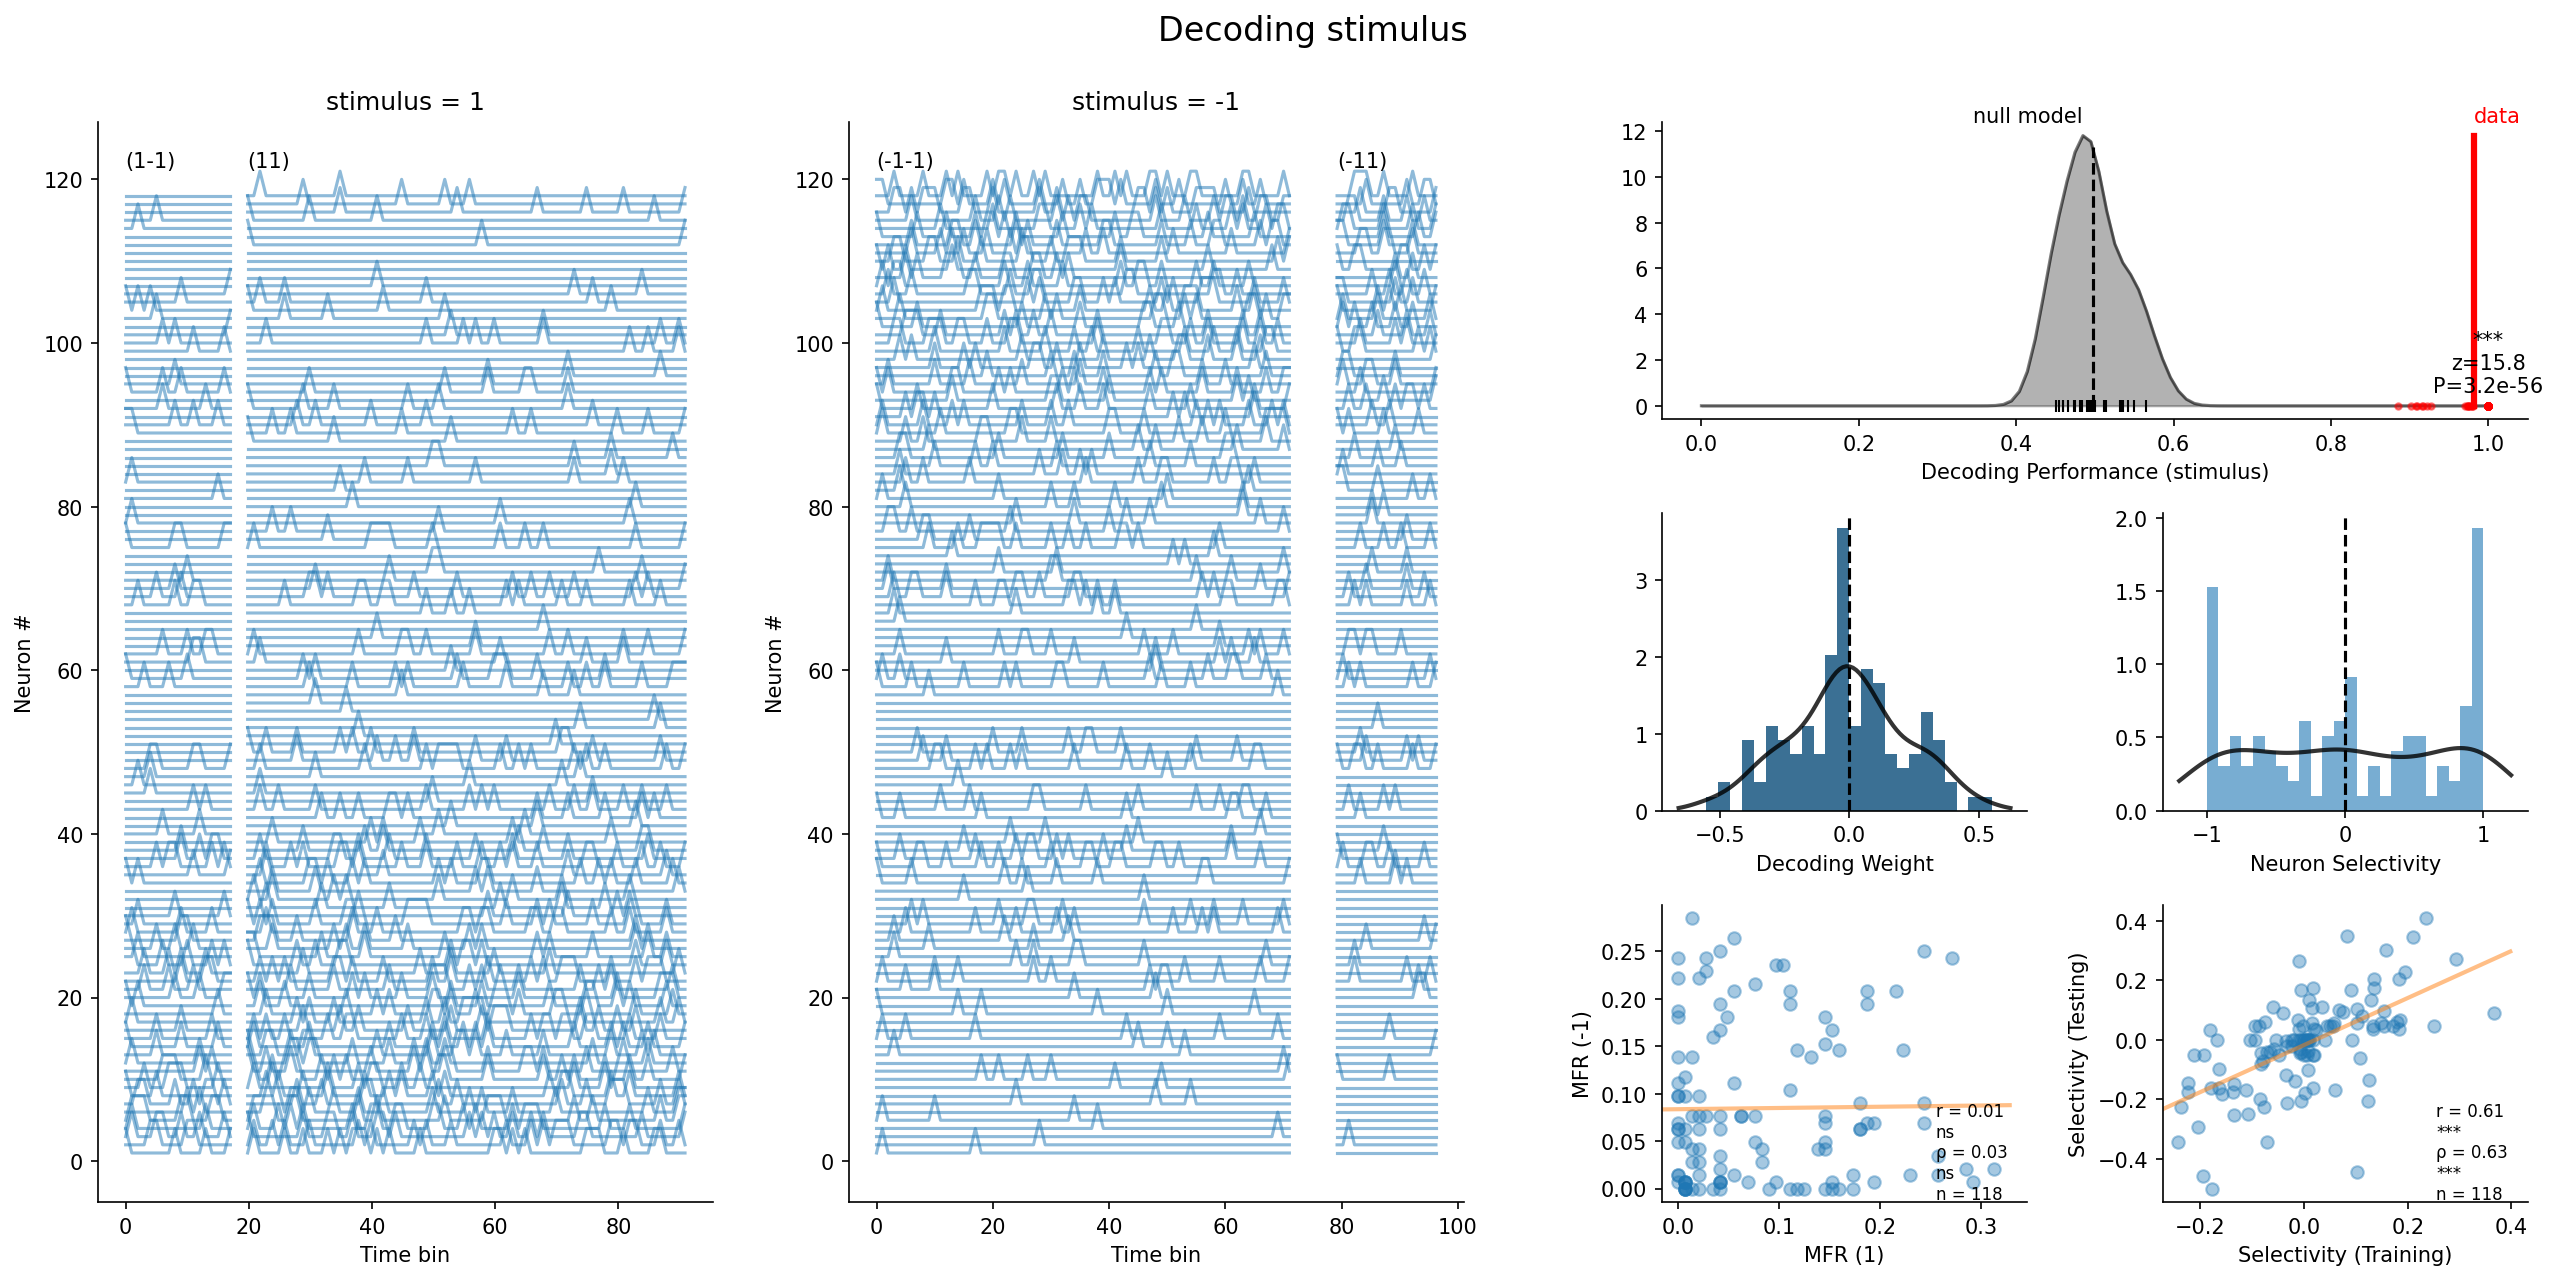

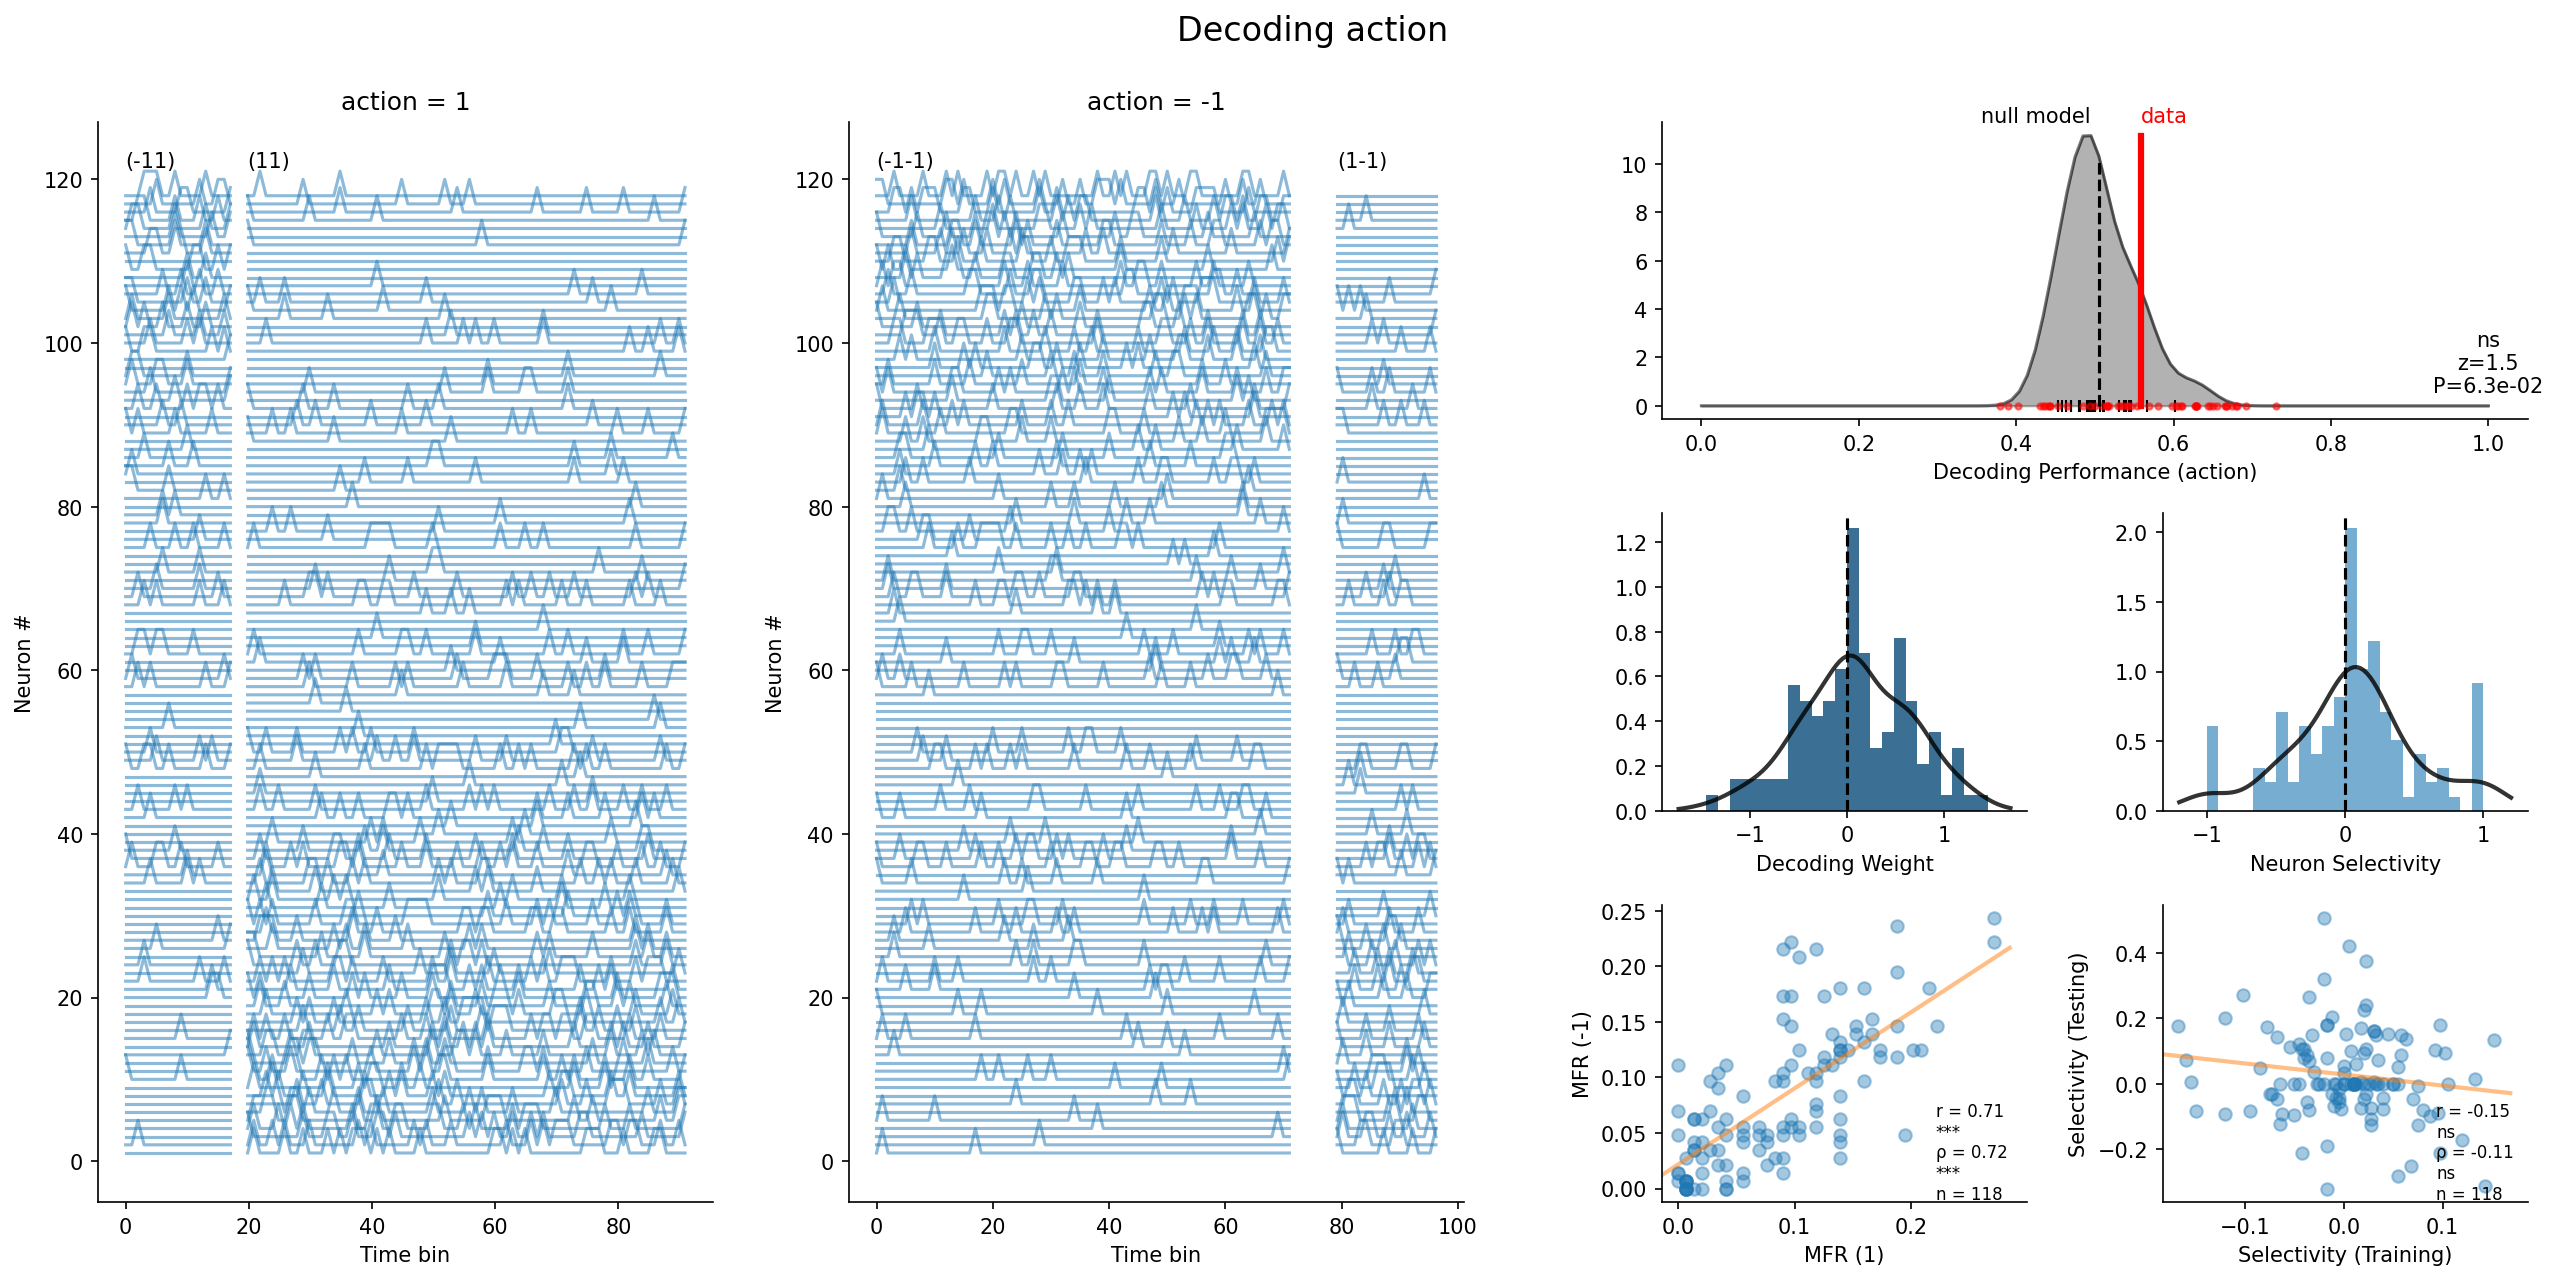

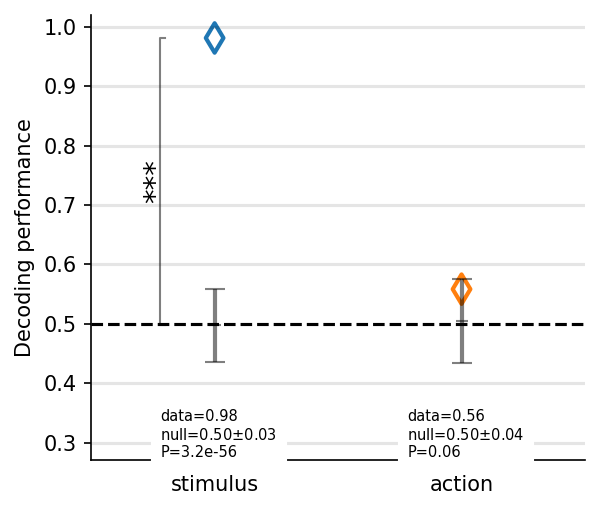

In [ ]:
#@title decode()
#@markdown The decodanda object exposes a simple interface for decoding the variables specified in the conditions dictionary:<br><br>```d.decode()```

#@markdown Importantly, it will decode each variable by balancing all non-decoded variables when sampling trials, so to avoid possible confounding effects.

#@markdown The main parameters are basically those we saw along this tutorial:

#@markdown the fraction of trials, or time bins, used for training the decoder during each cross validation fold:
training_fraction = 0.85 #@param {type:"slider", min:0, max:1.0, step:0.05}

#@markdown the number of cross validation folds:
cross_validations = 50 #@param {type:"number"}

#@markdown the number resampled trials, or time bins, per condition (this was called n_resampling above):
ndata = 200 #@param {type:"number"}

#@markdown the number of null model iterations. Each iteration repeats the whole decoding procedure including resampling ```ndata``` and performing ```cross_validations``` CV folds:
nshuffles =  25#@param {type:"number"}

perf, null = d.decode(training_fraction=training_fraction,
                      cross_validations=cross_validations,
                      nshuffles=nshuffles,
                      ndata=ndata,
                      plot=True,
                      plot_all=True,
                      ptype='z')



## Pseudo population
```Decodanda``` implements a pseudo-simultaneous population sampling logic to decode one or more variables from a pool of subjects with different number of trials and neurons.

It does so by concatenating vertically the sampled trials for each subject at the moment of creating the balanced classes for cross-validated decoding.

Let's see it in action!

In [ ]:
#@markdown Let's sample a few sessions whose activity have some response, but not too much, to the two stimuli ```A``` and ```B```
np.random.seed(0)

sessions = []

n_sessions = 5 #@param {type:"number"}
#@markdown Each session will have a random number of neurons and trials, and the same ```AB_separation``` value.
AB_separation = 1.75 #@param {type:"slider", min:0.1, max:5, step:0.1}

mean_n_neurons = 60 #@param {type:"number"}
mean_n_trials = 120 #@param {type:"number"}

for _ in range(n_sessions):

  n_neurons = int(np.random.rand()*2*mean_n_neurons)+10
  n_trials = int(np.random.rand()*2*mean_n_trials)+40

  activity, labels = generate_AB_activity(
      n_neurons,
      n_trials,
      AB_separation)

  sessions.append(
      {
          'raster': activity,
          'stimulus': labels,
          'trial': np.arange(len(labels))
      }
  )


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1):	Selected 105 time bin out of 210, divided into 105 trials 
			(stimulus = 1):	Selected 105 time bin out of 210, divided into 105 trials 



Testing decoding performance for semantic dichotomy:  stimulus
[['1'], ['0']] 100

[decode_dichotomy]	Decoding - 100 time bins - 75 neurons - 1 brains
		(1)
			vs.
		(-1)


 48%|████▊     | 12/25 [00:00<00:00, 93.89it/s]


Looping over decoding cross validation folds:


100%|██████████| 25/25 [00:00<00:00, 71.35it/s]



[decode_with_nullmodel]	 data <p> = 0.71

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:08<00:00,  3.06it/s]


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1):	Selected 33 time bin out of 66, divided into 33 trials 
			(stimulus = 1):	Selected 33 time bin out of 66, divided into 33 trials 



Testing decoding performance for semantic dichotomy:  stimulus
[['1'], ['0']] 100

[decode_dichotomy]	Decoding - 100 time bins - 66 neurons - 1 brains
		(1)
			vs.
		(-1)


100%|██████████| 25/25 [00:00<00:00, 158.05it/s]



Looping over decoding cross validation folds:

[decode_with_nullmodel]	 data <p> = 0.63

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:03<00:00,  6.57it/s]


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1):	Selected 92 time bin out of 184, divided into 92 trials 
			(stimulus = 1):	Selected 92 time bin out of 184, divided into 92 trials 



Testing decoding performance for semantic dichotomy:  stimulus
[['1'], ['0']] 100

[decode_dichotomy]	Decoding - 100 time bins - 40 neurons - 1 brains
		(1)
			vs.
		(-1)


100%|██████████| 25/25 [00:00<00:00, 249.02it/s]



Looping over decoding cross validation folds:

[decode_with_nullmodel]	 data <p> = 0.63

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:01<00:00, 13.21it/s]


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1):	Selected 111 time bin out of 222, divided into 111 trials 
			(stimulus = 1):	Selected 111 time bin out of 222, divided into 111 trials 



Testing decoding performance for semantic dichotomy:  stimulus
[['1'], ['0']] 100

[decode_dichotomy]	Decoding - 100 time bins - 100 neurons - 1 brains
		(1)
			vs.
		(-1)


100%|██████████| 25/25 [00:00<00:00, 142.35it/s]



Looping over decoding cross validation folds:

[decode_with_nullmodel]	 data <p> = 0.73

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:06<00:00,  4.12it/s]


		[Decodanda]	building conditioned rasters for session 0
			(stimulus = -1):	Selected 108 time bin out of 216, divided into 108 trials 
			(stimulus = 1):	Selected 108 time bin out of 216, divided into 108 trials 



Testing decoding performance for semantic dichotomy:  stimulus
[['1'], ['0']] 100

[decode_dichotomy]	Decoding - 100 time bins - 110 neurons - 1 brains
		(1)
			vs.
		(-1)


100%|██████████| 25/25 [00:00<00:00, 155.93it/s]



Looping over decoding cross validation folds:

[decode_with_nullmodel]	 data <p> = 0.75

[decode_with_nullmodel]	Looping over null model shuffles.


100%|██████████| 25/25 [00:04<00:00,  5.94it/s]







Mean individual performance = 0.690




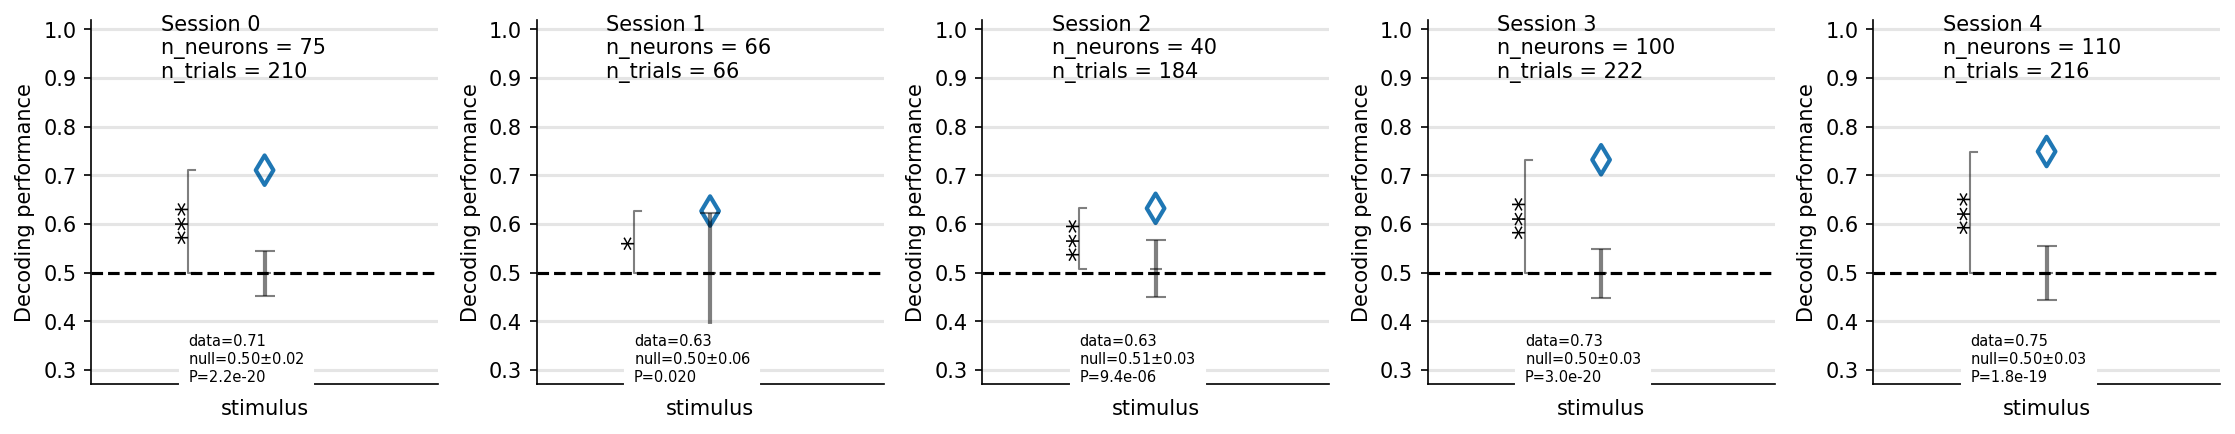

In [ ]:
#@markdown Let's see how well we can decode the stimulus from these sessions individually

conditions = {'stimulus': [-1, 1]}

training_fraction =  0.8 #@param {type:"slider", min:0.1, max:0.98, step:0.01}
cross_validations = 25 #@param {type:"number"}
n_resampling = 100 #@param {type:"number"}
nshuffles = 25 #@param {type:"number"}

f, axs = plt.subplots(1, n_sessions, figsize=(3*n_sessions, 3))

individual_performances = []
for i, session in enumerate(sessions):
  d = Decodanda(session, conditions, verbose=True, trial_chunk=1)
  perf, null = d.decode(training_fraction=training_fraction,
                      cross_validations=cross_validations,
                      nshuffles=nshuffles,
                      ndata=n_resampling,
                      plot=True, ptype='z', ax=axs[i])
  axs[i].text(-0.3, 0.9, 'Session %u\nn_neurons = %u\nn_trials = %u' % (i, session['raster'].shape[1], session['raster'].shape[0]))
  individual_performances.append(perf['stimulus'])

print('\n\n\n\n\nMean individual performance = %.3f\n\n' % np.mean(individual_performances))

In [ ]:
#@markdown There is something, but overall the results are not very flashy. Let's now make these sessions join forces and decode from their combined data!

#@markdown In ```Decodanda```, it is automatically handled by passing a list of sessions to the constructor as the first attribute

d = Decodanda(sessions, conditions, verbose=True)



In [ ]:
#@markdown Let's see how well we can decode the stimulus from all the sessions combined!

perf, null = d.decode(training_fraction=training_fraction,
                      cross_validations=cross_validations,
                      nshuffles=nshuffles,
                      ndata=n_resampling,
                      plot=True, ptype='z',
                      plot_all=True)


**That's all folks** (for now)

<div style="display: flex; justify-content: row;">
    <img src="https://i.giphy.com/media/xUPOqo6E1XvWXwlCyQ/giphy.webp">
</div>

Please save this notebook for later consultation, play with parameters and try to implement these functions yourself.

Follow the [GitHub repo](https://github.com/lposani/decodanda) to stay updated on the ```Decodanda``` package!

In all cases, good luck on your decoding journey!

